# Table of Contents
<p>
<div class="lev1 toc-item">
    <a href="#Cargamos-transacciones-de-Enero-2016" data-toc-modified-id="Cargamos-transacciones-de-Enero-2016">
        <span class="toc-item-num">1&nbsp;&nbsp;</span>
        Cargamos transacciones de Enero 2016</a></div>

<div class="lev2 toc-item">
    <a href="#Limpieza-de-transacciones" data-toc-modified-id="Limpieza-de-transacciones">
    <span class="toc-item-num">1.1&nbsp;&nbsp;</span>
    Limpieza de transacciones</a></div>

<div class="lev1 toc-item">
    <a href="#Cargamos-datos-de-ubicación-geográfica" data-toc-modified-id="Cargamos-datos-de-ubicación-geográfica">
    <span class="toc-item-num">2&nbsp;&nbsp;</span>
    Cargamos datos de ubicación geográfica</a></div>
    
<div class="lev1 toc-item">
    <a href="#Cargamos-datos-de-capacidad-de-plazas" data-toc-modified-id="Cargamos-datos-de-capacidad-de-plazas">
    <span class="toc-item-num">3&nbsp;&nbsp;</span>
    Cargamos datos de capacidad de plazas</a></div>

<div class="lev1 toc-item">
    <a href="#Relacionamos-transacciones,-ubicaciones-y-capacidad" data-toc-modified-id="Relacionamos-transacciones,-ubicaciones-y-capacidad">
    <span class="toc-item-num">4&nbsp;&nbsp;</span>
    Relacionamos transacciones, ubicaciones y capacidad</a></div>
    
<div class="lev1 toc-item">
    <a href="#Análisis-de-tickets-diarios-por-parquímetro" data-toc-modified-id="Análisis-de-tickets-diarios-por-parquímetro">
    <span class="toc-item-num">5&nbsp;&nbsp;</span>
    Análisis de tickets diarios por parquímetro</a></div>
       
<div class="lev1 toc-item">
    <a href="#Construímos-la-serie-de-ocupación-por-timestamp" data-toc-modified-id="Construímos-la-serie-de-ocupación-por-timestamp">
    <span class="toc-item-num">6&nbsp;&nbsp;</span>
    Construímos la serie de ocupación por timestamp</a></div>
    
<div class="lev1 toc-item">
    <a href="#Análisis-de-un-parquímetro-concreto" data-toc-modified-id="Análisis-de-un-parquímetro-concreto">
    <span class="toc-item-num">7&nbsp;&nbsp;</span>
    Análisis de un parquímetro concreto</a></div>
    
<div class="lev1 toc-item">
    <a href="#Top-15%-parquímetros-con-más-transacciones" data-toc-modified-id="Top-15%-parquímetros-con-más-transacciones">
    <span class="toc-item-num">8&nbsp;&nbsp;</span>
    Top 15% parquímetros con más transacciones</a></div>

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
% matplotlib inline

## Cargamos transacciones de Enero 2016

In [2]:
df = pd.read_csv(os.path.join('./data/ParkingTransaction_2016_cleaned.csv'), 
                           parse_dates=['TransactionDateTime'])

In [3]:
df['TransactionDateTime'].describe()

count                10935395
unique                5505469
top       2016-04-08 12:03:59
freq                       63
first     2016-01-01 11:49:15
last      2016-12-31 20:00:51
Name: TransactionDateTime, dtype: object

Acotamos inicialmente el dataset al mes de Enero para facilitar un primer análisis

In [4]:
df = df.loc[df['TransactionDateTime'].dt.month == 1]     

In [5]:
import re

_underscorer1 = re.compile(r'(.)([A-Z][a-z]+)')
_underscorer2 = re.compile('([a-z0-9])([A-Z])')

def camelToSnake(s):
    subbed = _underscorer1.sub(r'\1_\2', s)
    return _underscorer2.sub(r'\1_\2', subbed).lower()

In [6]:
df.columns = df.columns.map(lambda x: camelToSnake(x))

df.transaction_date = pd.to_datetime(df.transaction_date, format="%Y-%m-%d")
df.sort_values('transaction_date_time', inplace=True)

# creamos nueva columna 'final_date_time'
df['final_date_time'] = df.transaction_date_time.add(pd.to_timedelta(df.duration_mins, unit="m"))

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 843102 entries, 8 to 843065
Data columns (total 12 columns):
unnamed: 0               843102 non-null int64
transaction_id           843102 non-null int64
transaction_date_time    843102 non-null datetime64[ns]
transaction_date         843102 non-null datetime64[ns]
time_start               843102 non-null object
time_expired             843102 non-null object
duration_mins            843102 non-null int64
amount                   843102 non-null float64
payment_mean             843055 non-null object
meter_code               843102 non-null int64
element_key              843102 non-null int64
final_date_time          843102 non-null datetime64[ns]
dtypes: datetime64[ns](3), float64(1), int64(5), object(3)
memory usage: 217.5 MB


In [7]:
df = df.drop(columns=['unnamed: 0','amount','payment_mean','meter_code'])

In [8]:
df.head()

,transaction_id,transaction_date_time,transaction_date,time_start,time_expired,duration_mins,element_key,final_date_time
8,183506786,2016-01-01 11:49:15,2016-01-01,11:49,11:49,0,54730,2016-01-01 11:49:15
4,183511748,2016-01-01 12:36:04,2016-01-01,12:36,12:36,0,88773,2016-01-01 12:36:04
17,183511753,2016-01-01 12:36:08,2016-01-01,12:36,12:36,0,88773,2016-01-01 12:36:08
15,183529739,2016-01-01 12:40:30,2016-01-01,12:40,12:40,0,57354,2016-01-01 12:40:30
12,183527118,2016-01-01 14:52:45,2016-01-01,14:52,14:52,0,76102,2016-01-01 14:52:45


### Limpieza de transacciones

In [9]:
df.isnull().sum()  # no hay valores nulos

transaction_id           0
transaction_date_time    0
transaction_date         0
time_start               0
time_expired             0
duration_mins            0
element_key              0
final_date_time          0
dtype: int64

In [10]:
# Observamos algunas transacciones con duración = 0
df.duration_mins.loc[df.duration_mins == 0].count()

391

In [11]:
# Las eliminamos porque suponen menos de un 0.05% del total
df = df.loc[df.duration_mins != 0]

In [12]:
# Eliminamos también aquellas transacciones con hora final entre las 0 y las 8, 
# por estar fuera del rango horario de uso de los parquímetros. Suponen un 0.5% del total.
df = df.loc[df.final_date_time.dt.hour > 8]

In [13]:
# Eliminamos también aquellas transacciones con hora inicial mayor que 20,
# por estar fuera del rango horario de uso de los parquímetros. Suponen menos de un 0.4% del total. 
df = df.loc[df.transaction_date_time.dt.hour < 20]

In [14]:
# Eliminamos también aquellas transacciones realizadas por error en domingo
df = df.loc[df.transaction_date_time.dt.weekday != 6]

In [15]:
df.shape  # con la limpieza hemos reducido el tamaño del dataset menos de un 1.9%.

(827298, 8)

## Cargamos datos de ubicación geográfica

In [16]:
coord = pd.read_csv(os.path.join('./data/Coord_EK.csv'))

In [17]:
coord.head()

,element_key,latitude,longitude
0,1001,47.602862,-122.334703
1,1002,47.602997,-122.334538
2,1005,47.603602,-122.335382
3,1006,47.603725,-122.335171
4,1009,47.605010,-122.336669


In [18]:
coord.element_key.duplicated().sum()

0

## Cargamos datos de capacidad de plazas

In [19]:
blocks = pd.read_csv(os.path.join('./data/Blockface_cleaned.csv'))

In [20]:
blocks.columns = blocks.columns.map(lambda x: camelToSnake(x))

In [21]:
blocks[blocks.element_key == 1001]

,pay_station_blockface_id,element_key,parking_spaces,paid_parking_area,parking_time_limit_category,peak_hour_start1,peak_hour_end1,peak_hour_start2,peak_hour_end2,paid_area_start_time,...,saturday_start1,saturday_end1,saturday_rate2,saturday_start2,saturday_end2,saturday_rate3,saturday_start3,saturday_end3,start_time_saturday,end_time_saturday
469,7576,1001,5.0,Pioneer Square,120.0,06:00:00,09:00:00,15:00:00,18:00:00,08:00:00,...,08:00:00,11:00:00,4.0,11:00:00,18:00:00,NaN,NaN,NaN,08:00:00,18:00:00
2783,10071,1001,5.0,Pioneer Square,120.0,06:00:00,09:00:00,15:00:00,18:00:00,08:00:00,...,08:00:00,11:00:00,4.5,11:00:00,18:00:00,NaN,NaN,NaN,08:00:00,18:00:00
3017,10262,1001,4.0,Pioneer Square,120.0,06:00:00,09:00:00,15:00:00,18:00:00,08:00:00,...,08:00:00,11:00:00,4.5,11:00:00,18:00:00,NaN,NaN,NaN,08:00:00,18:00:00
4648,11976,1001,4.0,NaN,120.0,06:00:00,09:00:00,15:00:00,18:00:00,NaN,...,00:00:00,00:00:00,0.0,00:00:00,00:00:00,0.0,00:00:00,00:00:00,NaN,NaN
5989,13670,1001,4.0,Pioneer Square,120.0,06:00:00,09:00:00,15:00:00,18:00:00,08:00:00,...,08:00:00,11:00:00,4.5,11:00:00,18:00:00,NaN,NaN,NaN,08:00:00,18:00:00
6301,14348,1001,5.0,Pioneer Square,120.0,06:00:00,09:00:00,15:00:00,18:00:00,08:00:00,...,08:00:00,11:00:00,5.0,11:00:00,18:00:00,NaN,NaN,NaN,08:00:00,18:00:00
7077,13939,1001,5.0,Pioneer Square,120.0,06:00:00,09:00:00,15:00:00,18:00:00,08:00:00,...,08:00:00,11:00:00,4.5,11:00:00,18:00:00,NaN,NaN,NaN,08:00:00,18:00:00
8059,3405,1001,5.0,Pioneer Square,120.0,06:00:00,09:00:00,15:00:00,18:00:00,08:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10576,1352,1001,7.0,Pioneer Square,120.0,06:00:00,09:00:00,15:00:00,18:00:00,08:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11332,6046,1001,5.0,Pioneer Square,120.0,06:00:00,09:00:00,15:00:00,18:00:00,08:00:00,...,08:00:00,11:00:00,3.5,11:00:00,18:00:00,NaN,NaN,NaN,08:00:00,18:00:00


Como hay algunos casos como el anterior donde hay divergencia en la información de plazas asociadas a un mismo element_key, calculamos la media redondeada a un valor entero de los distintos valores existentes.

In [22]:
park_spaces = blocks.groupby('element_key')['parking_spaces'].mean()

In [23]:
park_spaces = park_spaces.reset_index(level=['element_key'])

In [24]:
park_spaces.parking_spaces.loc[park_spaces.parking_spaces.isnull()]

141   NaN
Name: parking_spaces, dtype: float64

In [25]:
park_spaces = park_spaces.dropna()  # eliminamos un valor nulo

In [26]:
park_spaces.parking_spaces = np.rint(park_spaces.parking_spaces).astype(int)

In [27]:
# park_spaces.to_csv('./data/Parking_Spaces.csv', index=False)

In [28]:
park_spaces.element_key.duplicated().sum()

0

In [29]:
park_spaces.head()

,element_key,parking_spaces
0,1001,5
1,1002,9
2,1005,5
3,1006,5
4,1009,5


## Relacionamos transacciones, ubicaciones y capacidad

In [30]:
df.element_key.unique().size

1464

In [31]:
coord.element_key.unique().size

1517

In [32]:
park_spaces.element_key.unique().size

1707

In [33]:
len(set(coord.element_key).intersection(set(df.element_key)))

1405

In [34]:
len(set(park_spaces.element_key).intersection(set(df.element_key)))

1463

**Mezclamos los datasets:**

In [35]:
df_c = pd.merge(df, coord, on='element_key', how='inner', validate='many_to_one')

In [36]:
df_cp = pd.merge(df_c, park_spaces, on='element_key', how='inner', validate='many_to_one')

In [37]:
df.shape, df_c.shape, df_cp.shape

((827298, 8), (806100, 10), (806100, 11))

In [38]:
df_cp.transaction_id.duplicated().sum()

0

In [39]:
df_cp.set_index('transaction_id', inplace=True)
df_cp.head()

,transaction_date_time,transaction_date,time_start,time_expired,duration_mins,element_key,final_date_time,latitude,longitude,parking_spaces
transaction_id,,,,,,,,,,
64059668,2016-01-02 00:19:07,2016-01-02,00:19,10:17,598,35693,2016-01-02 10:17:07,47.619158,-122.346457,7
64059669,2016-01-02 00:21:55,2016-01-02,00:21,10:19,598,35693,2016-01-02 10:19:55,47.619158,-122.346457,7
64084672,2016-01-02 07:52:55,2016-01-02,07:52,14:02,370,35693,2016-01-02 14:02:55,47.619158,-122.346457,7
183563751,2016-01-02 08:10:02,2016-01-02,08:10,09:10,60,35693,2016-01-02 09:10:02,47.619158,-122.346457,7
64084673,2016-01-02 08:22:59,2016-01-02,08:22,10:22,120,35693,2016-01-02 10:22:59,47.619158,-122.346457,7


## Análisis de tickets diarios por parquímetro

In [40]:
df_cp.element_key.unique().size

1405

In [41]:
# Top 15 de parquímetros con más transacciones
df_cp.groupby('element_key').parking_spaces.count().sort_values(ascending=False).head(15)

element_key
31853    4931
1234     3779
35845    3533
54737    3303
35850    3246
35846    2869
13213    2710
1233     2404
24406    2334
36158    2322
2922     2303
31850    2285
9474     2186
9353     2114
81210    2091
Name: parking_spaces, dtype: int64

Días que transcurren en el dataset:

In [42]:
first_moment = df_cp.transaction_date_time.iloc[0]
last_moment = df_cp.transaction_date_time.iloc[-1]
time_elapsed = last_moment - first_moment
time_elapsed

Timedelta('28 days 13:53:15')

Tickets al día promedio por parquímetro:

In [43]:
parkimeter_ticket_by_day = df_cp.groupby('element_key').parking_spaces.count() / time_elapsed.days
parkimeter_ticket_by_day.sort_values(ascending=False, inplace=True)
parkimeter_ticket_by_day.name = 'tickets_by_day'
parkimeter_ticket_by_day.head(15)

element_key
31853    176.107143
1234     134.964286
35845    126.178571
54737    117.964286
35850    115.928571
35846    102.464286
13213     96.785714
1233      85.857143
24406     83.357143
36158     82.928571
2922      82.250000
31850     81.607143
9474      78.071429
9353      75.500000
81210     74.678571
Name: tickets_by_day, dtype: float64

In [44]:
parkimeter_ticket_by_day.tail(15)

element_key
75282    0.428571
12538    0.428571
12601    0.357143
7246     0.250000
13509    0.178571
58225    0.178571
47970    0.107143
76201    0.107143
8858     0.107143
8854     0.107143
9762     0.035714
10054    0.035714
13510    0.035714
13301    0.035714
13138    0.035714
Name: tickets_by_day, dtype: float64

In [45]:
parkimeter_ticket_by_day.quantile(np.linspace(0, 1, 21))

0.00      0.035714
0.05      2.721429
0.10      4.392857
0.15      6.385714
0.20      7.678571
0.25      9.142857
0.30     10.614286
0.35     12.192857
0.40     13.714286
0.45     14.964286
0.50     16.714286
0.55     18.542857
0.60     20.392857
0.65     22.571429
0.70     24.850000
0.75     27.642857
0.80     30.757143
0.85     34.478571
0.90     39.592857
0.95     50.264286
1.00    176.107143
Name: tickets_by_day, dtype: float64

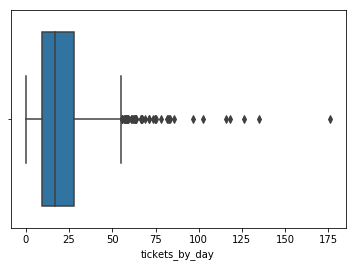

In [46]:
sns.boxplot(parkimeter_ticket_by_day);

## Construímos la serie de ocupación por timestamp

Construímos la tabla corta primero que usaremos para montar las series temporales:

In [47]:
in_cols = ['element_key', 'latitude', 'longitude', 'transaction_date_time', 'parking_spaces']
out_cols = ['element_key', 'latitude', 'longitude', 'final_date_time', 'parking_spaces']

df_in = df_cp[in_cols].reset_index()
df_in.transaction_id = df_in.transaction_id.map(lambda s:'%s_in' % str(s))
df_in['timestamp_sign'] = 1.0
df_in.rename(columns={'transaction_date_time': 'timestamp'}, inplace=True)

df_out = df_cp[out_cols].reset_index()
df_out.transaction_id = df_out.transaction_id.map(lambda s:'%s_out' % str(s))
df_out['timestamp_sign'] = - 1.0
df_out.rename(columns={'final_date_time': 'timestamp'}, inplace=True)  # inplace = True, value of copy is ignored

In [48]:
df_in.head()

,transaction_id,element_key,latitude,longitude,timestamp,parking_spaces,timestamp_sign
0,64059668_in,35693,47.619158,-122.346457,2016-01-02 00:19:07,7,1.0
1,64059669_in,35693,47.619158,-122.346457,2016-01-02 00:21:55,7,1.0
2,64084672_in,35693,47.619158,-122.346457,2016-01-02 07:52:55,7,1.0
3,183563751_in,35693,47.619158,-122.346457,2016-01-02 08:10:02,7,1.0
4,64084673_in,35693,47.619158,-122.346457,2016-01-02 08:22:59,7,1.0


In [49]:
df_out.head()

,transaction_id,element_key,latitude,longitude,timestamp,parking_spaces,timestamp_sign
0,64059668_out,35693,47.619158,-122.346457,2016-01-02 10:17:07,7,-1.0
1,64059669_out,35693,47.619158,-122.346457,2016-01-02 10:19:55,7,-1.0
2,64084672_out,35693,47.619158,-122.346457,2016-01-02 14:02:55,7,-1.0
3,183563751_out,35693,47.619158,-122.346457,2016-01-02 09:10:02,7,-1.0
4,64084673_out,35693,47.619158,-122.346457,2016-01-02 10:22:59,7,-1.0


In [50]:
full_transactions = pd.concat([df_in, df_out])
full_transactions.set_index('transaction_id', inplace=True)
full_transactions.sort_values('timestamp', ascending=True, inplace=True)

In [51]:
full_transactions.head()

,element_key,latitude,longitude,timestamp,parking_spaces,timestamp_sign
transaction_id,,,,,,
64059668_in,35693,47.619158,-122.346457,2016-01-02 00:19:07,7,1.0
64059669_in,35693,47.619158,-122.346457,2016-01-02 00:21:55,7,1.0
64059649_in,53549,47.628175,-122.341132,2016-01-02 00:46:40,32,1.0
64059641_in,9393,47.621441,-122.335970,2016-01-02 03:14:33,5,1.0
64059674_in,11133,47.619815,-122.348131,2016-01-02 04:51:28,5,1.0


In [52]:
df_in.shape, df_out.shape, full_transactions.shape

((806100, 7), (806100, 7), (1612200, 6))

## Análisis de un parquímetro concreto

In [53]:
full_transactions.reset_index(drop=True)
ek1234 = full_transactions[full_transactions.element_key == 1234]

In [54]:
ek1234.shape

(7558, 6)

In [55]:
ek1234.timestamp = ek1234.timestamp.map(lambda x: x.replace(microsecond=0,second=0,minute=0))

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [56]:
ek1234['occupation'] = ek1234.groupby('timestamp').timestamp_sign.transform(lambda series: series.cumsum())

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [57]:
ek1234 = ek1234.reset_index(drop=True)

Limpiamos los duplicados por parquímetro seleccionando los valores últimos para que se hayan agregado las operaciones simultáneas

In [58]:
ek1234.drop_duplicates(subset=['timestamp'], keep='last', inplace=True)

In [59]:
ek1234.head(30)

,element_key,latitude,longitude,timestamp,parking_spaces,timestamp_sign,occupation
3,1234,47.61471,-122.319331,2016-01-02 08:00:00,27,1.0,4.0
22,1234,47.61471,-122.319331,2016-01-02 09:00:00,27,1.0,15.0
44,1234,47.61471,-122.319331,2016-01-02 10:00:00,27,-1.0,0.0
75,1234,47.61471,-122.319331,2016-01-02 11:00:00,27,-1.0,1.0
111,1234,47.61471,-122.319331,2016-01-02 12:00:00,27,-1.0,2.0
148,1234,47.61471,-122.319331,2016-01-02 13:00:00,27,-1.0,-3.0
187,1234,47.61471,-122.319331,2016-01-02 14:00:00,27,1.0,7.0
235,1234,47.61471,-122.319331,2016-01-02 15:00:00,27,1.0,-4.0
266,1234,47.61471,-122.319331,2016-01-02 16:00:00,27,-1.0,-1.0
294,1234,47.61471,-122.319331,2016-01-02 17:00:00,27,1.0,0.0


Ocupación media a través de las horas del día:

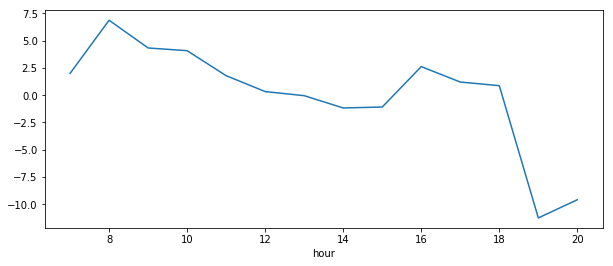

In [60]:
ek1234['hour'] = ek1234.timestamp.dt.hour
occupation_by_hour_key = ek1234.groupby(['hour']).occupation
occupation_by_hour_key.mean().plot(figsize=(10, 4));

In [61]:
occupation_by_hour_key.describe().head(25)

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
7,12.0,2.000000,1.279204,1.0,1.00,1.0,3.00,4.0
8,24.0,6.875000,3.791438,1.0,4.00,6.5,9.25,17.0
9,24.0,4.333333,4.018075,-4.0,2.00,4.5,7.00,15.0
10,24.0,4.083333,4.292731,-6.0,1.00,4.5,8.00,11.0
11,24.0,1.791667,3.776117,-5.0,-1.00,1.5,5.00,8.0
12,24.0,0.333333,3.726132,-10.0,-2.00,0.0,2.25,8.0
13,24.0,-0.041667,4.378596,-5.0,-3.25,-0.5,1.25,15.0
14,24.0,-1.166667,3.897231,-10.0,-4.00,0.0,1.25,7.0
15,24.0,-1.083333,3.133503,-6.0,-3.25,-1.0,1.00,4.0


In [62]:
ek1234['day_year'] = ek1234.timestamp.dt.dayofyear

In [63]:
ek1234['occu_cum'] = ek1234.groupby('day_year').occupation.agg('cumsum')

In [64]:
ek1234['occupation_perc'] = (ek1234.occu_cum / ek1234.parking_spaces * 100.0).map("{0:.2f}".format)

In [65]:
ek1234.head()

,element_key,latitude,longitude,timestamp,parking_spaces,timestamp_sign,occupation,hour,day_year,occu_cum,occupation_perc
3,1234,47.61471,-122.319331,2016-01-02 08:00:00,27,1.0,4.0,8,2,4.0,14.81
22,1234,47.61471,-122.319331,2016-01-02 09:00:00,27,1.0,15.0,9,2,19.0,70.37
44,1234,47.61471,-122.319331,2016-01-02 10:00:00,27,-1.0,0.0,10,2,19.0,70.37
75,1234,47.61471,-122.319331,2016-01-02 11:00:00,27,-1.0,1.0,11,2,20.0,74.07
111,1234,47.61471,-122.319331,2016-01-02 12:00:00,27,-1.0,2.0,12,2,22.0,81.48


## Top 15% parquímetros con más transacciones

In [66]:
N = np.rint(0.15 * df_cp.element_key.unique().size).astype(int)  # 211 parquímetros
top15 = df_cp.groupby('element_key').parking_spaces.count().sort_values(ascending=False).head(N)

In [67]:
top15_list = list(top15.index)

In [68]:
top15_transactions = full_transactions[full_transactions.element_key.isin(top15_list)]

In [69]:
top15_transactions.element_key.unique().size  # comprobamos

211

In [70]:
top15_transactions.timestamp = top15_transactions.timestamp.map(lambda x: x.replace(microsecond=0,second=0,minute=0))

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [71]:
top15_transactions['occupation'] = top15_transactions.groupby(['element_key', 'timestamp']).timestamp_sign.transform(
    lambda series: series.cumsum())

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [72]:
top15_transactions = top15_transactions.reset_index(drop=True)

In [73]:
top15_transactions.drop_duplicates(subset=['element_key','timestamp'], keep='last', inplace=True)

In [74]:
top15_transactions['day_year'] = top15_transactions.timestamp.dt.dayofyear

In [75]:
top15_transactions['occu_cum'] = top15_transactions.groupby(['element_key','day_year']).occupation.agg('cumsum')

In [76]:
top15_transactions['occupation_perc'] = (top15_transactions.occu_cum / top15_transactions.parking_spaces * 100.0).map(
    "{0:.2f}".format).astype(float)

In [77]:
top15_transactions.head(30)

,element_key,latitude,longitude,timestamp,parking_spaces,timestamp_sign,occupation,day_year,occu_cum,occupation_perc
0,35242,47.662434,-122.317343,2016-01-02 05:00:00,14,1.0,1.0,2,1.0,7.14
1,34506,47.621271,-122.332867,2016-01-02 06:00:00,31,1.0,1.0,2,1.0,3.23
2,86450,47.669376,-122.386098,2016-01-02 06:00:00,14,1.0,1.0,2,1.0,7.14
3,37186,47.615173,-122.320241,2016-01-02 07:00:00,6,1.0,1.0,2,1.0,16.67
4,58513,47.657933,-122.313319,2016-01-02 07:00:00,9,1.0,1.0,2,1.0,11.11
5,69446,47.613507,-122.316700,2016-01-02 07:00:00,10,1.0,1.0,2,1.0,10.00
6,2921,47.600475,-122.331714,2016-01-02 07:00:00,14,1.0,1.0,2,1.0,7.14
7,31889,47.614501,-122.347519,2016-01-02 07:00:00,16,1.0,1.0,2,1.0,6.25
10,35838,47.654700,-122.313188,2016-01-02 07:00:00,12,1.0,1.0,2,1.0,8.33
11,52525,47.616354,-122.343798,2016-01-02 07:00:00,12,1.0,1.0,2,1.0,8.33


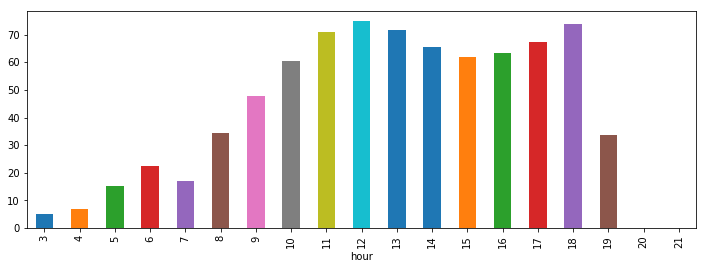

In [78]:
top15_transactions['hour'] = top15_transactions.timestamp.dt.hour
perc_occupation_by_hour = top15_transactions.groupby(['hour']).occupation_perc.mean()
perc_occupation_by_hour.plot(kind='bar',figsize=(12, 4));

In [79]:
top15_transactions[['element_key','latitude','longitude','timestamp','occupation_perc']].to_csv(
    './data/Top15_EK_2016.csv')